<a href="https://colab.research.google.com/github/vladislavlisin/ICR/blob/main/ICR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Данная тетрадка посвещена соревнованию на kaggle:** https://www.kaggle.com/competitions/icr-identify-age-related-conditions

Задача бинарной классификации: У пациента есть одно из трёх заболеваний (1 класс) или нет ни одного заболевания (класс 0)

В настоящее время такие модели, как XGBoost и случайный лес, используются для прогнозирования заболеваний, но производительность моделей недостаточно высока. Имея дело с критическими проблемами, когда на карту поставлены жизни, модели должны надежно и последовательно делать правильные прогнозы для разных случаев.

Представления оцениваются с использованием сбалансированного логарифмического проигрыша . Общий эффект таков, что каждый класс примерно одинаково важен для окончательного результата.

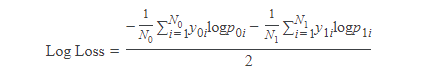

где (N_{c}) — количество наблюдений класса (c), (\ log) — натуральный логарифм, (y_{ci}) равно 1, если наблюдение (i) принадлежит классу (c), и 0 в противном случае, (p_{ci}) — прогнозируемая вероятность того, что наблюдение (i) принадлежит классу (c).

Представленные вероятности для данной строки не обязаны суммироваться до единицы, потому что они масштабируются до подсчета очков (каждая строка делится на сумму строки). Чтобы избежать крайностей логарифмической функции, каждая прогнозируемая вероятность
заменяется на

Lisin Vladislav

In [2]:
def balanced_log_loss(y1, y0, p1, p0, N0, N1):

  sum1 = (y1 * np.log(p1)).sum()
  sum0 = (y0 * np.log(p0)).sum()

  if N0 != 0:
    LogLoss0 = ( (1/N0)*sum0 )
  else:
    LogLoss0 = 0

  if N1 != 0:
    LogLoss1 = ( (1/N1)*sum1 )
  else:
    LogLoss1 = 0

  return -0.5*(LogLoss1 + LogLoss0)

**Требования к коду**

Заявки на участие в этом конкурсе должны подаваться через Notebooks. Чтобы кнопка «Отправить» была активна после коммита, должны быть выполнены следующие условия:

1. Ноутбук с процессором <= 9 часов работы
2. Ноутбук с графическим процессором <= 9 часов работы
3. Доступ в Интернет отключен
4. Файл отправки должен быть названsubmission.csv

Информация по данным:

train.csv — тренировочный набор.
Id Уникальный идентификатор для каждого наблюдения.

AB- GL Пятьдесят шесть анонимных характеристик здоровья. Все числовые, за исключением EJ, который является категориальным.

In [3]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.1 MB/s eta 0:00:00


In [4]:
import sklearn
import pandas as pd
import seaborn as sbn
import numpy as np


from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
df_train = pd.read_csv("/content/drive/MyDrive/ICR - Identifying Age-Related Conditions/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/ICR - Identifying Age-Related Conditions/test.csv")

have a look at data

1. describe
2.

In [6]:
df_train

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,...,0.173229,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,0
613,fd895603f071,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,...,10.223150,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340,0
614,fd8ef6377f76,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,...,0.173229,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000,0
615,fe1942975e40,0.363205,1263.53524,85.200147,23.685856,8.138688,7.981959,0.025578,7.524588,1.229900,...,9.256996,0.78764,0.670527,24.594488,72.611063,1965.343176,25.116750,37.155112,0.184622,0


In [7]:
df_test

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,00eed32682bb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,010ebe33f668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,02fa521e1838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,040e15f562a2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,046e85c7cc7f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
y = df_train.Class

df_test = df_test.drop(["Id"], axis=1)
ds_train = df_train.drop(["Id", "Class"], axis=1)

In [9]:
ds_train.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,617.000000,616.000000,617.000000,615.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000
mean,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,5350.388655,...,10.111079,5.433199,3.533905,0.421501,20.724856,131.714987,14679.595398,31.489716,50.584437,8.530961
std,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,3021.326641,...,2.934025,11.496257,50.181948,1.305365,9.991907,144.181524,19352.959387,9.864239,36.266251,10.327010
min,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,...,3.583450,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129
25%,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,4155.702870,...,8.523098,0.173229,0.497060,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124392
50%,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,4997.960730,...,9.945452,3.028141,1.131000,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.337827
75%,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,6035.885700,...,11.516657,6.238814,1.512060,0.535067,25.608406,127.591671,19035.709240,36.863947,67.931664,21.978000
max,6.161666,28688.187660,1910.123198,630.518230,178.943634,38.270880,10.315851,38.971568,1463.693448,53060.599240,...,35.851039,137.932739,1244.227020,31.365763,135.781294,1497.351958,143790.071200,81.210825,191.194764,21.978000


In [10]:
ds_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 56 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AB      617 non-null    float64
 1   AF      617 non-null    float64
 2   AH      617 non-null    float64
 3   AM      617 non-null    float64
 4   AR      617 non-null    float64
 5   AX      617 non-null    float64
 6   AY      617 non-null    float64
 7   AZ      617 non-null    float64
 8   BC      617 non-null    float64
 9   BD      617 non-null    float64
 10  BN      617 non-null    float64
 11  BP      617 non-null    float64
 12  BQ      557 non-null    float64
 13  BR      617 non-null    float64
 14  BZ      617 non-null    float64
 15  CB      615 non-null    float64
 16  CC      614 non-null    float64
 17  CD      617 non-null    float64
 18  CF      617 non-null    float64
 19  CH      617 non-null    float64
 20  CL      617 non-null    float64
 21  CR      617 non-null    float64
 22  CS

In [12]:
# замэпим категориальные данные (она у нас одна, поэтому просто бинарно закодируем)

mapping = {"A": 1,
           "B": 0}

map_train = ds_train.copy(deep=True)

map_train['EJ'] = ds_train.EJ.map(mapping)
df_test["EJ"] = df_test.EJ.map(mapping)

map_train.EJ

0      0
1      1
2      0
3      0
4      0
      ..
612    1
613    0
614    1
615    0
616    1
Name: EJ, Length: 617, dtype: int64

In [25]:
cols_list = df_train.isnull().sum()[lambda x: x != 0]
cols_list

BQ    60
CB     2
CC     3
DU     1
EL    60
FC     1
FL     1
FS     2
GL     1
dtype: int64

In [20]:
# посчитаем количество уникальных значений, в основном как оказалось признаки не дискретны

def count_unique(df : pd.DataFrame):
  for i in df.columns:
    print(i, len(df[i].unique()))

count_unique(ds_train)

AB 217
AF 599
AH 227
AM 605
AR 130
AX 427
AY 148
AZ 484
BC 259
BD  617
BN 53
BP 612
BQ 516
BR 566
BZ 115
CB 554
CC 603
CD  584
CF 586
CH 135
CL 123
CR 595
CS 576
CU 307
CW  426
DA 611
DE 616
DF 137
DH 191
DI 571
DL 604
DN 576
DU 254
DV 39
DY 590
EB 439
EE 513
EG 610
EH 127
EJ 2
EL 312
EP 275
EU 455
FC 601
FD  337
FE 615
FI 498
FL 389
FR 435
FS 162
GB 560
GE 264
GF 611
GH 596
GI 615
GL 356


In [26]:
from sklearn.impute import SimpleImputer

# EJ - КАТЕГОРИАЛЬНЫЙ, БЕЗ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ, ОСТАЛЬНЫЕ ЧИСЛОВЫЕ

imp_med = SimpleImputer(missing_values=np.nan, strategy='median')

imp_med.fit(map_train)

df_test = pd.DataFrame(imp_med.transform(df_test), columns=df_test.columns)
imp_ds_train = pd.DataFrame(imp_med.transform(map_train), columns=map_train.columns)

In [27]:
imp_ds_train.isnull().sum()[lambda x: x != 0]

Series([], dtype: int64)

In [28]:
imp_ds_train.head(10)

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL
0,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343
1,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000
2,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941
3,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829
4,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614
5,0.209377,2615.81430,85.200147,8.541526,8.138688,4.013127,0.025578,12.547282,1.229900,5237.54088,...,10.981896,0.173229,0.49706,1.164956,21.915512,72.611063,24177.595550,28.525186,82.527764,21.978000
6,0.348249,1733.65412,85.200147,8.377385,15.312480,1.913544,0.025578,6.547778,1.229900,5710.46099,...,10.777915,4.408484,0.86130,0.467337,17.878444,192.453107,3332.467494,34.166222,100.086808,0.065096
7,0.269199,966.45483,85.200147,21.174189,8.138688,4.987617,0.025578,9.408886,1.229900,5040.77914,...,10.342388,6.591896,0.49706,0.277693,18.445866,109.693986,21371.759850,35.208102,31.424696,0.092873
8,0.346113,3238.43674,85.200147,28.888816,8.138688,4.021986,0.025578,8.243016,3.626448,6569.37001,...,11.450501,4.762291,1.18262,0.067730,17.245908,147.218610,4589.611956,29.771721,54.675576,0.073416
9,0.324748,5188.68207,85.200147,12.968687,8.138688,4.593392,0.025578,10.685041,1.229900,4951.69863,...,12.329825,0.173229,1.57151,0.318331,24.515421,98.929757,5563.130949,21.994831,33.300970,21.978000


# **SEARCH**

In [29]:
# lets try pandas_profiling

# !pip install ydata-profiling

In [30]:
!python3 -m PIL | grep -i type

--- FREETYPE2 support ok, loaded 2.11.0


In [31]:
#!pip install --upgrade Pillow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 34.3 MB/s eta 0:00:00
  Attempting uninstall: Pillow
    Found existing installation: Pillow 8.4.0
    Uninstalling Pillow-8.4.0:
      Successfully uninstalled Pillow-8.4.0


In [32]:
#!pip install --upgrade pip

In [33]:
# from ydata_profiling import ProfileReport

# profile = ProfileReport(df_train, title="Profiling Report")

In [34]:
# a lot of mistakes
# profile

# **Модельная часть**

In [35]:
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score as bas, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt

def evaluate_metrics(model, X, y):

  print("!")
  preds = model.predict(X)
  prob_preds = model.predict_proba(X)

  # conf mat and balanced acc

  print("Сбалансированная точность", bas(y, preds))
  print("Матрица неточностей \n", confusion_matrix(y, preds))

  # base metrica
  # threshold

  preds1 = preds
  preds0 = 1 - preds1
  N0 = preds0.sum()
  N1 = preds1.sum()

  ll = balanced_log_loss(y1 = preds1, y0 = preds0 , p1 = prob_preds[:, 1], p0 = prob_preds[:, 0], N0=N0, N1=N1)
  print("Сбалансированный LogLoss", ll)

  # all in all

  print(classification_report(y, preds))

  # AUC ROC

  lr_probs = prob_preds[:, 1]
  # рассчитываем ROC AUC
  lr_auc = roc_auc_score(y, lr_probs)
  print('ROC AUC=%.3f' % (lr_auc))

  """
  # рассчитываем roc-кривую
  fpr, tpr, treshold = roc_curve(y_test, lr_probs)
  roc_auc = auc(fpr, tpr)
  # строим график
  plt.plot(fpr, tpr, color='darkorange',
           label='ROC кривая (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Пример ROC-кривой')
  plt.legend(loc="lower right")
  plt.show()
  """

  return ll

# **fight with disbalance**

In [37]:
from imblearn.combine import SMOTETomek

smt = SMOTETomek(sampling_strategy="not majority" , random_state=42)
X_res, y_res = smt.fit_resample(imp_ds_train, y)


In [38]:
s = y_res.value_counts()
all = y_res.value_counts().sum()
print(s)
print(s[0]/all, s[1]/all)

1    488
0    488
Name: Class, dtype: int64
0.5 0.5


In [39]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_res, y_res, random_state=1, stratify=y_res, test_size=0.15)

In [40]:
# Как распределены классы

s = y.value_counts()
all = y.value_counts().sum()
print(s)
print(s[0]/all, s[1]/all)

# зверский дисбаланс
#  делаем чтонибуть с этим

from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
print(class_weights)
class_weight = {0: class_weights[0], 1: class_weights[1]}

reset_x_train = x_train.reset_index()
reset_y_train = y_train.reset_index().drop(["index"], axis=1)
X = imp_ds_train

0    509
1    108
Name: Class, dtype: int64
0.8249594813614263 0.17504051863857376
[0.60609037 2.85648148]


# **Optuna**

In [41]:
from sklearn.svm import SVC
from statistics import mean
import optuna as o
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.feature_selection import RFECV

# 1. Define an objective function to be maximized.
def objective_svc(trial):

    reg_C_param = trial.suggest_float("C", 0.00001, 2.0, log=True)
    kernel_type_param = trial.suggest_categorical('kernel', ['poly', 'rbf', 'sigmoid'])

    svc = SVC(C=reg_C_param,
              kernel=kernel_type_param,
              gamma='scale',
              probability=True,
              tol=0.001,
              class_weight=class_weight,
              random_state=1)

    scores = cross_val_score(svc, reset_x_train, y=reset_y_train, scoring=evaluate_metrics, cv=5, n_jobs=-1)

    print(scores)
    return mean(scores)

# 3. Create a study object and optimize the objective function.
study = o.create_study(direction='minimize')
study.optimize(objective_svc, n_trials=50)

#get best parameters
print("\n\nBEST PARAMETERS : \n", study.best_params)

print("\n\nBEST VALUES : \n", study.best_value)

print("\n\nBEST TRIAL : \n", study.best_trial)

#  0.5398932209183075 with optuna + class_weight

[I 2023-07-13 10:38:09,464] A new study created in memory with name: no-name-7431cb44-a048-47e8-a7cd-8ef1af51bdb7
[I 2023-07-13 10:38:14,122] Trial 0 finished with value: 0.4163713106797232 and parameters: {'C': 4.522896888093156e-05, 'kernel': 'rbf'}. Best is trial 0 with value: 0.4163713106797232.


[0.43799732 0.39924155 0.41606169 0.3941456  0.4344104 ]


[I 2023-07-13 10:38:15,233] Trial 1 finished with value: 0.3841921938859549 and parameters: {'C': 0.0022431927780220506, 'kernel': 'poly'}. Best is trial 1 with value: 0.3841921938859549.


[0.35203805 0.33607807 0.36814501 0.34134972 0.52335012]


[I 2023-07-13 10:38:17,881] Trial 2 finished with value: 0.7149758065768188 and parameters: {'C': 0.6864113437880722, 'kernel': 'sigmoid'}. Best is trial 1 with value: 0.3841921938859549.


[0.82356401 0.82887605 0.63762772 0.7818737  0.50293755]


[I 2023-07-13 10:38:21,166] Trial 3 finished with value: 0.34687826877176176 and parameters: {'C': 1.6362465218569865e-05, 'kernel': 'sigmoid'}. Best is trial 3 with value: 0.34687826877176176.


[0.33504176 0.33794395 0.34816708 0.33945725 0.3737813 ]


[I 2023-07-13 10:38:22,629] Trial 4 finished with value: 0.3781689602418873 and parameters: {'C': 0.0012167659439770637, 'kernel': 'poly'}. Best is trial 3 with value: 0.34687826877176176.


[0.35708515 0.34685345 0.35900986 0.34991436 0.47798198]


[I 2023-07-13 10:38:23,579] Trial 5 finished with value: 0.38792643483775746 and parameters: {'C': 0.00018380992408770246, 'kernel': 'poly'}. Best is trial 3 with value: 0.34687826877176176.


[0.38265404 0.35704759 0.37908758 0.35556539 0.46527757]


[I 2023-07-13 10:38:25,068] Trial 6 finished with value: 0.3524988668493068 and parameters: {'C': 0.012842004028643838, 'kernel': 'sigmoid'}. Best is trial 3 with value: 0.34687826877176176.


[0.37188371 0.37185615 0.34657359 0.35366952 0.31851136]


[I 2023-07-13 10:38:25,777] Trial 7 finished with value: 0.3789457677231284 and parameters: {'C': 0.0003653707722062649, 'kernel': 'poly'}. Best is trial 3 with value: 0.34687826877176176.


[0.37849905 0.35569723 0.35637464 0.35527233 0.44888559]


[I 2023-07-13 10:38:26,659] Trial 8 finished with value: 0.7170791978033884 and parameters: {'C': 0.11044249859268959, 'kernel': 'sigmoid'}. Best is trial 3 with value: 0.34687826877176176.


[0.86668045 0.87724353 0.34657359 0.81542293 0.67947549]


[I 2023-07-13 10:38:27,578] Trial 9 finished with value: 0.3540464817982826 and parameters: {'C': 0.025490397481538, 'kernel': 'sigmoid'}. Best is trial 3 with value: 0.34687826877176176.


[0.3716153  0.37164729 0.34657359 0.35358752 0.32680872]


[I 2023-07-13 10:38:28,373] Trial 10 finished with value: 0.4166794473072801 and parameters: {'C': 1.239716089855251e-05, 'kernel': 'rbf'}. Best is trial 3 with value: 0.34687826877176176.


[0.42953559 0.40442191 0.41606169 0.39896764 0.4344104 ]


[I 2023-07-13 10:38:29,258] Trial 11 finished with value: 0.3525959530173294 and parameters: {'C': 0.007987071238699383, 'kernel': 'sigmoid'}. Best is trial 3 with value: 0.34687826877176176.


[0.37317584 0.37242527 0.34657359 0.35350831 0.31729675]


[I 2023-07-13 10:38:30,097] Trial 12 finished with value: 0.35250123648870674 and parameters: {'C': 0.012951862087660197, 'kernel': 'sigmoid'}. Best is trial 3 with value: 0.34687826877176176.


[0.37188371 0.371868   0.34657359 0.35366952 0.31851136]


[I 2023-07-13 10:38:30,914] Trial 13 finished with value: 0.3459691245831571 and parameters: {'C': 0.00010652983670838305, 'kernel': 'sigmoid'}. Best is trial 13 with value: 0.3459691245831571.


[0.34619182 0.34459673 0.34362233 0.3433948  0.35203994]


[I 2023-07-13 10:38:31,713] Trial 14 finished with value: 0.34741431240423626 and parameters: {'C': 2.1811182901422833e-05, 'kernel': 'sigmoid'}. Best is trial 13 with value: 0.3459691245831571.


[0.33505615 0.3387052  0.34818294 0.33894023 0.37618703]


[I 2023-07-13 10:38:32,782] Trial 15 finished with value: 0.3458004259276005 and parameters: {'C': 0.0001118311707898453, 'kernel': 'sigmoid'}. Best is trial 15 with value: 0.3458004259276005.


[0.34619182 0.34525631 0.34362233 0.34189172 0.35203994]


[I 2023-07-13 10:38:34,042] Trial 16 finished with value: 0.41674525701850573 and parameters: {'C': 9.527098925279283e-05, 'kernel': 'rbf'}. Best is trial 15 with value: 0.3458004259276005.


[0.43799732 0.39924155 0.41606169 0.39588038 0.43454535]


[I 2023-07-13 10:38:35,409] Trial 17 finished with value: 0.3424851363774707 and parameters: {'C': 0.0006279523727215832, 'kernel': 'sigmoid'}. Best is trial 17 with value: 0.3424851363774707.


[0.36273966 0.36619601 0.33617792 0.35450004 0.29281206]


[I 2023-07-13 10:38:36,799] Trial 18 finished with value: 0.34387918874784035 and parameters: {'C': 0.0007654985805435667, 'kernel': 'sigmoid'}. Best is trial 17 with value: 0.3424851363774707.


[0.36229803 0.36600473 0.33498037 0.35349828 0.30261454]


[I 2023-07-13 10:38:38,020] Trial 19 finished with value: 0.3693611761387153 and parameters: {'C': 0.0007654908738236314, 'kernel': 'rbf'}. Best is trial 17 with value: 0.3424851363774707.


[0.37066369 0.36142079 0.36535349 0.35855885 0.39080906]


[I 2023-07-13 10:38:38,861] Trial 20 finished with value: 0.34513394062100083 and parameters: {'C': 0.002393186787358482, 'kernel': 'sigmoid'}. Best is trial 17 with value: 0.3424851363774707.


[0.36678247 0.37155873 0.34657359 0.35372865 0.28702626]


[I 2023-07-13 10:38:39,708] Trial 21 finished with value: 0.3462966700257158 and parameters: {'C': 0.0026042548164221507, 'kernel': 'sigmoid'}. Best is trial 17 with value: 0.3424851363774707.


[0.36687827 0.3718706  0.34657359 0.35442328 0.29173762]


[I 2023-07-13 10:38:40,532] Trial 22 finished with value: 0.34307929141384824 and parameters: {'C': 0.0005451038602436386, 'kernel': 'sigmoid'}. Best is trial 17 with value: 0.3424851363774707.


[0.35904885 0.36321968 0.3369437  0.35450004 0.30168419]


[I 2023-07-13 10:38:41,356] Trial 23 finished with value: 0.34599133033492074 and parameters: {'C': 0.00041788115442067193, 'kernel': 'sigmoid'}. Best is trial 17 with value: 0.3424851363774707.


[0.3590894  0.35644635 0.33435911 0.35654652 0.32351526]


[I 2023-07-13 10:38:42,202] Trial 24 finished with value: 0.3424227482287687 and parameters: {'C': 0.0006440635287200875, 'kernel': 'sigmoid'}. Best is trial 24 with value: 0.3424227482287687.


[0.36317504 0.36619601 0.33617792 0.35375272 0.29281206]


[I 2023-07-13 10:38:43,019] Trial 25 finished with value: 0.349830160066991 and parameters: {'C': 0.00023210857817534174, 'kernel': 'sigmoid'}. Best is trial 24 with value: 0.3424227482287687.


[0.35535057 0.35713822 0.33857852 0.36142181 0.33666169]


[I 2023-07-13 10:38:43,855] Trial 26 finished with value: 0.3429998005417633 and parameters: {'C': 0.0005683942077912881, 'kernel': 'sigmoid'}. Best is trial 24 with value: 0.3424227482287687.


[0.35904885 0.36282222 0.3369437  0.35450004 0.30168419]


[I 2023-07-13 10:38:44,675] Trial 27 finished with value: 0.3526334330096304 and parameters: {'C': 0.004399564002257323, 'kernel': 'sigmoid'}. Best is trial 24 with value: 0.3424227482287687.


[0.37411349 0.37230899 0.34657359 0.35311161 0.31705948]


[I 2023-07-13 10:38:45,302] Trial 28 finished with value: 0.37802261946948973 and parameters: {'C': 0.0012347045477393544, 'kernel': 'poly'}. Best is trial 24 with value: 0.3424227482287687.


[0.35767812 0.34541191 0.35913681 0.34948113 0.47840513]


[I 2023-07-13 10:38:46,091] Trial 29 finished with value: 0.416371310632932 and parameters: {'C': 4.4781529499906666e-05, 'kernel': 'rbf'}. Best is trial 24 with value: 0.3424227482287687.


[0.43799732 0.39924155 0.41606169 0.3941456  0.4344104 ]


[I 2023-07-13 10:38:46,842] Trial 30 finished with value: 0.3751197225385781 and parameters: {'C': 0.00031361182652379037, 'kernel': 'rbf'}. Best is trial 24 with value: 0.3424227482287687.


[0.39195991 0.37696138 0.37465793 0.36340062 0.36861878]


[I 2023-07-13 10:38:47,671] Trial 31 finished with value: 0.3419669993548464 and parameters: {'C': 0.0006611228349996661, 'kernel': 'sigmoid'}. Best is trial 31 with value: 0.3419669993548464.


[0.36238778 0.36532234 0.3355601  0.35375272 0.29281206]


[I 2023-07-13 10:38:48,834] Trial 32 finished with value: 0.344310999228781 and parameters: {'C': 0.0012916415257463636, 'kernel': 'sigmoid'}. Best is trial 31 with value: 0.3419669993548464.


[0.3624205  0.37285912 0.33505019 0.35374665 0.29747854]


[I 2023-07-13 10:38:50,182] Trial 33 finished with value: 0.34262324823112184 and parameters: {'C': 0.0006241829362292622, 'kernel': 'sigmoid'}. Best is trial 31 with value: 0.3419669993548464.


[0.36273966 0.36619601 0.33686848 0.35450004 0.29281206]


[I 2023-07-13 10:38:51,512] Trial 34 finished with value: 0.3502426963111101 and parameters: {'C': 0.00023392136904672886, 'kernel': 'sigmoid'}. Best is trial 31 with value: 0.3419669993548464.


[0.35711532 0.35713822 0.33857852 0.36171974 0.33666169]


[I 2023-07-13 10:38:52,940] Trial 35 finished with value: 0.34445300089234265 and parameters: {'C': 0.00107197753224845, 'kernel': 'sigmoid'}. Best is trial 31 with value: 0.3419669993548464.


[0.36275119 0.37203944 0.33696116 0.35405368 0.29645953]


[I 2023-07-13 10:38:53,869] Trial 36 finished with value: 0.38344944354139293 and parameters: {'C': 0.0018242755398741365, 'kernel': 'poly'}. Best is trial 31 with value: 0.3419669993548464.


[0.3563938  0.33821915 0.36046848 0.34312856 0.51903723]


[I 2023-07-13 10:38:54,734] Trial 37 finished with value: 0.3460142654360349 and parameters: {'C': 0.0029861176309366874, 'kernel': 'sigmoid'}. Best is trial 31 with value: 0.3419669993548464.


[0.36630416 0.37155055 0.34657359 0.35401585 0.29162719]


[I 2023-07-13 10:38:55,373] Trial 38 finished with value: 0.3762801215729946 and parameters: {'C': 0.0005774885312409707, 'kernel': 'poly'}. Best is trial 31 with value: 0.3419669993548464.


[0.35449775 0.34485475 0.36820649 0.35109689 0.46274473]


[I 2023-07-13 10:38:56,224] Trial 39 finished with value: 0.34980191205242267 and parameters: {'C': 0.00017027755801128693, 'kernel': 'sigmoid'}. Best is trial 31 with value: 0.3419669993548464.


[0.34980969 0.36034723 0.34213507 0.35065584 0.34606173]


[I 2023-07-13 10:38:57,053] Trial 40 finished with value: 0.3465896580912169 and parameters: {'C': 0.0003351307780624116, 'kernel': 'sigmoid'}. Best is trial 31 with value: 0.3419669993548464.


[0.35764632 0.3546093  0.33732255 0.3634204  0.31994972]


[I 2023-07-13 10:38:57,930] Trial 41 finished with value: 0.3446491694356714 and parameters: {'C': 0.0006015392601935466, 'kernel': 'sigmoid'}. Best is trial 31 with value: 0.3419669993548464.


[0.36273966 0.36382741 0.33709207 0.35450004 0.30508667]


[I 2023-07-13 10:38:58,751] Trial 42 finished with value: 0.34819632528758665 and parameters: {'C': 0.001534096653844603, 'kernel': 'sigmoid'}. Best is trial 31 with value: 0.3419669993548464.


[0.36425543 0.37397846 0.34650173 0.35543307 0.30081294]


[I 2023-07-13 10:38:59,551] Trial 43 finished with value: 0.34440877136235637 and parameters: {'C': 0.0008785298186378344, 'kernel': 'sigmoid'}. Best is trial 31 with value: 0.3419669993548464.


[0.36340796 0.36747668 0.33454968 0.35399501 0.30261454]


[I 2023-07-13 10:39:00,385] Trial 44 finished with value: 0.34225326967560493 and parameters: {'C': 0.00046487321140253174, 'kernel': 'sigmoid'}. Best is trial 31 with value: 0.3419669993548464.


[0.35835866 0.35738428 0.33472501 0.35568826 0.30511014]


[I 2023-07-13 10:39:01,198] Trial 45 finished with value: 0.35053924958789245 and parameters: {'C': 0.003976504863404937, 'kernel': 'sigmoid'}. Best is trial 31 with value: 0.3419669993548464.


[0.37440218 0.37180055 0.34657359 0.35417386 0.30574606]


[I 2023-07-13 10:39:01,790] Trial 46 finished with value: 0.3837745461083167 and parameters: {'C': 0.001973936880143628, 'kernel': 'poly'}. Best is trial 31 with value: 0.3419669993548464.


[0.35480295 0.3373919  0.36424341 0.34266713 0.51976734]


[I 2023-07-13 10:39:02,590] Trial 47 finished with value: 0.3488917440913207 and parameters: {'C': 0.00014939183653320552, 'kernel': 'sigmoid'}. Best is trial 31 with value: 0.3419669993548464.


[0.35363288 0.36103648 0.3411199  0.34985379 0.33881567]


[I 2023-07-13 10:39:03,430] Trial 48 finished with value: 0.34710792229421966 and parameters: {'C': 0.00035261421416949454, 'kernel': 'sigmoid'}. Best is trial 31 with value: 0.3419669993548464.


[0.36025834 0.35419438 0.33684095 0.36027466 0.32397128]


[I 2023-07-13 10:39:04,644] Trial 49 finished with value: 0.3467140236155672 and parameters: {'C': 7.181223543170507e-05, 'kernel': 'sigmoid'}. Best is trial 31 with value: 0.3419669993548464.


[0.33507484 0.33665278 0.34842827 0.34108225 0.37233199]


BEST PARAMETERS : 
 {'C': 0.0006611228349996661, 'kernel': 'sigmoid'}


BEST VALUES : 
 0.3419669993548464


BEST TRIAL : 
 FrozenTrial(number=31, state=TrialState.COMPLETE, values=[0.3419669993548464], datetime_start=datetime.datetime(2023, 7, 13, 10, 38, 46, 843687), datetime_complete=datetime.datetime(2023, 7, 13, 10, 38, 47, 671281), params={'C': 0.0006611228349996661, 'kernel': 'sigmoid'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'C': FloatDistribution(high=2.0, log=True, low=1e-05, step=None), 'kernel': CategoricalDistribution(choices=('poly', 'rbf', 'sigmoid'))}, trial_id=31, value=None)


In [42]:
# lets do some baseline model - linear model

from sklearn.linear_model import LogisticRegression

# Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.
# elastic only for saga
# Solver newton-cholesky supports only 'l2' or 'none' penalties, got l1 penalty.

# 1. Define an objective function to be maximized.
def objective_lr(trial):

    C = trial.suggest_float("C", 0.00001, 2.0, log=True)
    solver = trial.suggest_categorical('solver', ['liblinear', "lbfgs", 'newton-cholesky'])

    lr = LogisticRegression(penalty="l2",
                        C=C,
                        n_jobs=-1,
                        solver=solver,
                        class_weight = class_weight
                        )

    scores = cross_val_score(lr, reset_x_train, y=reset_y_train, scoring=evaluate_metrics, cv=5, n_jobs=-1)

    print(scores)
    return mean(scores)

# 3. Create a study object and optimize the objective function.
study = o.create_study(direction='minimize')
study.optimize(objective_lr, n_trials=50)

#get best parameters
print("\n\nBEST PARAMETERS : \n", study.best_params)

print("\n\nBEST VALUES : \n", study.best_value)

print("\n\nBEST TRIAL : \n", study.best_trial)

# Сбалансированный LogLoss 0.28583871302404357 - без class_weight
# Сбалансированный LogLoss 0.3558592211046744 - c class_weight
# Сбалансированный LogLoss 0.28156789812722566 - c class_weight + optuna

[I 2023-07-13 10:39:04,682] A new study created in memory with name: no-name-69cab23e-a8ba-4e28-811d-052a3fc917d0
[W 2023-07-13 10:39:05,150] Trial 0 failed with parameters: {'C': 0.00010402378029093247, 'solver': 'newton-cholesky'} because of the following error: The value nan is not acceptable..
[W 2023-07-13 10:39:05,152] Trial 0 failed with value nan.


[0.16783331        nan 0.15652242 0.16075359 0.16532837]


[W 2023-07-13 10:39:05,633] Trial 1 failed with parameters: {'C': 1.2121195057966891e-05, 'solver': 'lbfgs'} because of the following error: The value nan is not acceptable..
[W 2023-07-13 10:39:05,636] Trial 1 failed with value nan.


[       nan 0.19896656 0.19601471 0.19755391 0.19864044]


[W 2023-07-13 10:39:06,547] Trial 2 failed with parameters: {'C': 0.007065606591255725, 'solver': 'liblinear'} because of the following error: The value nan is not acceptable..
[W 2023-07-13 10:39:06,550] Trial 2 failed with value nan.


[nan nan nan nan nan]


[W 2023-07-13 10:39:07,652] Trial 3 failed with parameters: {'C': 0.08079040142462063, 'solver': 'liblinear'} because of the following error: The value nan is not acceptable..
[W 2023-07-13 10:39:07,654] Trial 3 failed with value nan.


[nan nan nan nan nan]


[W 2023-07-13 10:39:08,697] Trial 4 failed with parameters: {'C': 0.04661926304450059, 'solver': 'liblinear'} because of the following error: The value nan is not acceptable..
[W 2023-07-13 10:39:08,703] Trial 4 failed with value nan.


[nan nan nan nan nan]


[W 2023-07-13 10:39:09,221] Trial 5 failed with parameters: {'C': 0.00015276266245108826, 'solver': 'liblinear'} because of the following error: The value nan is not acceptable..
[W 2023-07-13 10:39:09,224] Trial 5 failed with value nan.


[0.16600379        nan 0.15052821 0.16368073 0.162052  ]


[W 2023-07-13 10:39:09,908] Trial 6 failed with parameters: {'C': 0.26877327467326445, 'solver': 'liblinear'} because of the following error: The value nan is not acceptable..
[W 2023-07-13 10:39:09,910] Trial 6 failed with value nan.


[nan nan nan nan nan]


[W 2023-07-13 10:39:10,237] Trial 7 failed with parameters: {'C': 0.10739644946489708, 'solver': 'lbfgs'} because of the following error: The value nan is not acceptable..
[W 2023-07-13 10:39:10,238] Trial 7 failed with value nan.


[       nan 0.17437458 0.17439178 0.18967172 0.18344895]


[W 2023-07-13 10:39:10,536] Trial 8 failed with parameters: {'C': 0.0006221450552095952, 'solver': 'lbfgs'} because of the following error: The value nan is not acceptable..
[W 2023-07-13 10:39:10,538] Trial 8 failed with value nan.


[       nan 0.20779635 0.18244116 0.18816801 0.18246848]


[W 2023-07-13 10:39:10,770] Trial 9 failed with parameters: {'C': 0.011652260923768643, 'solver': 'newton-cholesky'} because of the following error: The value nan is not acceptable..
[W 2023-07-13 10:39:10,773] Trial 9 failed with value nan.


[nan nan nan nan nan]


[I 2023-07-13 10:39:11,021] Trial 10 finished with value: 0.18053750451303174 and parameters: {'C': 2.3872685430737174e-05, 'solver': 'newton-cholesky'}. Best is trial 10 with value: 0.18053750451303174.


[0.18590202 0.18293551 0.17184471 0.17773508 0.18427021]


[I 2023-07-13 10:39:11,321] Trial 11 finished with value: 0.1889308611227488 and parameters: {'C': 9.406835758863762e-05, 'solver': 'lbfgs'}. Best is trial 10 with value: 0.18053750451303174.


[0.19576997 0.17987294 0.18843395 0.19095081 0.18962664]


[W 2023-07-13 10:39:11,549] Trial 12 failed with parameters: {'C': 0.011994917723810571, 'solver': 'newton-cholesky'} because of the following error: The value nan is not acceptable..
[W 2023-07-13 10:39:11,550] Trial 12 failed with value nan.


[nan nan nan nan nan]


[W 2023-07-13 10:39:11,788] Trial 13 failed with parameters: {'C': 8.635403477409892e-05, 'solver': 'newton-cholesky'} because of the following error: The value nan is not acceptable..
[W 2023-07-13 10:39:11,789] Trial 13 failed with value nan.


[0.16935671        nan 0.15908076 0.16208862 0.16799597]


[W 2023-07-13 10:39:12,199] Trial 14 failed with parameters: {'C': 0.001004501285362618, 'solver': 'liblinear'} because of the following error: The value nan is not acceptable..
[W 2023-07-13 10:39:12,202] Trial 14 failed with value nan.


[       nan        nan        nan        nan 0.14577334]


[W 2023-07-13 10:39:12,448] Trial 15 failed with parameters: {'C': 0.8600729197914719, 'solver': 'newton-cholesky'} because of the following error: The value nan is not acceptable..
[W 2023-07-13 10:39:12,451] Trial 15 failed with value nan.


[nan nan nan nan nan]


[I 2023-07-13 10:39:12,791] Trial 16 finished with value: 0.19085211311378797 and parameters: {'C': 0.8483203472334147, 'solver': 'lbfgs'}. Best is trial 10 with value: 0.18053750451303174.


[0.20290757 0.2014969  0.1649979  0.18977331 0.19508489]


[W 2023-07-13 10:39:13,030] Trial 17 failed with parameters: {'C': 0.061123097422396785, 'solver': 'newton-cholesky'} because of the following error: The value nan is not acceptable..
[W 2023-07-13 10:39:13,032] Trial 17 failed with value nan.


[nan nan nan nan nan]


[W 2023-07-13 10:39:13,619] Trial 18 failed with parameters: {'C': 0.12112137485861091, 'solver': 'liblinear'} because of the following error: The value nan is not acceptable..
[W 2023-07-13 10:39:13,621] Trial 18 failed with value nan.


[nan nan nan nan nan]


[W 2023-07-13 10:39:14,001] Trial 19 failed with parameters: {'C': 0.00013776773586062806, 'solver': 'lbfgs'} because of the following error: The value nan is not acceptable..
[W 2023-07-13 10:39:14,005] Trial 19 failed with value nan.


[       nan 0.17347896 0.16356839 0.1949037  0.18506417]


[W 2023-07-13 10:39:14,634] Trial 20 failed with parameters: {'C': 7.185601263307598e-05, 'solver': 'newton-cholesky'} because of the following error: The value nan is not acceptable..
[W 2023-07-13 10:39:14,637] Trial 20 failed with value nan.


[0.17100194        nan 0.16175808 0.16490613 0.16987213]


[W 2023-07-13 10:39:15,203] Trial 21 failed with parameters: {'C': 0.018035204358586854, 'solver': 'liblinear'} because of the following error: The value nan is not acceptable..
[W 2023-07-13 10:39:15,205] Trial 21 failed with value nan.


[nan nan nan nan nan]


[W 2023-07-13 10:39:15,447] Trial 22 failed with parameters: {'C': 0.001572126412890593, 'solver': 'newton-cholesky'} because of the following error: The value nan is not acceptable..
[W 2023-07-13 10:39:15,450] Trial 22 failed with value nan.


[       nan        nan        nan        nan 0.14103073]


[W 2023-07-13 10:39:15,709] Trial 23 failed with parameters: {'C': 0.5471396372435599, 'solver': 'newton-cholesky'} because of the following error: The value nan is not acceptable..
[W 2023-07-13 10:39:15,711] Trial 23 failed with value nan.


[nan nan nan nan nan]


[W 2023-07-13 10:39:15,945] Trial 24 failed with parameters: {'C': 0.48770078704438624, 'solver': 'newton-cholesky'} because of the following error: The value nan is not acceptable..
[W 2023-07-13 10:39:15,946] Trial 24 failed with value nan.


[nan nan nan nan nan]


[W 2023-07-13 10:39:16,474] Trial 25 failed with parameters: {'C': 0.002666285321975028, 'solver': 'liblinear'} because of the following error: The value nan is not acceptable..
[W 2023-07-13 10:39:16,476] Trial 25 failed with value nan.


[nan nan nan nan nan]


[W 2023-07-13 10:39:16,701] Trial 26 failed with parameters: {'C': 0.09360350967163193, 'solver': 'newton-cholesky'} because of the following error: The value nan is not acceptable..
[W 2023-07-13 10:39:16,704] Trial 26 failed with value nan.


[nan nan nan nan nan]


[W 2023-07-13 10:39:17,001] Trial 27 failed with parameters: {'C': 0.01256798525685622, 'solver': 'lbfgs'} because of the following error: The value nan is not acceptable..
[W 2023-07-13 10:39:17,003] Trial 27 failed with value nan.


[0.19352097        nan 0.17220686 0.19142626 0.1917148 ]


[I 2023-07-13 10:39:17,289] Trial 28 finished with value: 0.17976109949590788 and parameters: {'C': 3.894354905494551e-05, 'solver': 'liblinear'}. Best is trial 28 with value: 0.17976109949590788.


[0.18819434 0.17839348 0.16834039 0.18065458 0.18322271]


[W 2023-07-13 10:39:17,818] Trial 29 failed with parameters: {'C': 0.002727198728249358, 'solver': 'liblinear'} because of the following error: The value nan is not acceptable..
[W 2023-07-13 10:39:17,823] Trial 29 failed with value nan.


[nan nan nan nan nan]


[W 2023-07-13 10:39:18,094] Trial 30 failed with parameters: {'C': 7.034734551467293e-05, 'solver': 'newton-cholesky'} because of the following error: The value nan is not acceptable..
[W 2023-07-13 10:39:18,096] Trial 30 failed with value nan.


[0.17120901        nan 0.16207665 0.16523653 0.17020308]


[W 2023-07-13 10:39:18,332] Trial 31 failed with parameters: {'C': 0.02017924079160531, 'solver': 'newton-cholesky'} because of the following error: The value nan is not acceptable..
[W 2023-07-13 10:39:18,336] Trial 31 failed with value nan.


[nan nan nan nan nan]


[W 2023-07-13 10:39:18,700] Trial 32 failed with parameters: {'C': 0.00026790912685517744, 'solver': 'liblinear'} because of the following error: The value nan is not acceptable..
[W 2023-07-13 10:39:18,705] Trial 32 failed with value nan.


[0.16251503        nan        nan        nan 0.1565611 ]


[I 2023-07-13 10:39:18,973] Trial 33 finished with value: 0.18430562578423304 and parameters: {'C': 2.7891070469694226e-05, 'solver': 'liblinear'}. Best is trial 28 with value: 0.17976109949590788.


[0.19142501 0.18174283 0.17297766 0.18462075 0.19076188]


[W 2023-07-13 10:39:19,631] Trial 34 failed with parameters: {'C': 0.046547706557592904, 'solver': 'liblinear'} because of the following error: The value nan is not acceptable..
[W 2023-07-13 10:39:19,634] Trial 34 failed with value nan.


[nan nan nan nan nan]


[W 2023-07-13 10:39:19,964] Trial 35 failed with parameters: {'C': 0.16321162600650765, 'solver': 'newton-cholesky'} because of the following error: The value nan is not acceptable..
[W 2023-07-13 10:39:19,969] Trial 35 failed with value nan.


[nan nan nan nan nan]


[W 2023-07-13 10:39:20,511] Trial 36 failed with parameters: {'C': 0.5279883931511226, 'solver': 'lbfgs'} because of the following error: The value nan is not acceptable..
[W 2023-07-13 10:39:20,514] Trial 36 failed with value nan.


[       nan 0.1771262  0.17059696 0.18865708 0.18978528]


[W 2023-07-13 10:39:21,550] Trial 37 failed with parameters: {'C': 0.4300729834840502, 'solver': 'liblinear'} because of the following error: The value nan is not acceptable..
[W 2023-07-13 10:39:21,553] Trial 37 failed with value nan.


[nan nan nan nan nan]


[W 2023-07-13 10:39:21,963] Trial 38 failed with parameters: {'C': 0.00016366990988781285, 'solver': 'newton-cholesky'} because of the following error: The value nan is not acceptable..
[W 2023-07-13 10:39:21,968] Trial 38 failed with value nan.


[0.16416819        nan        nan        nan 0.15984362]


[W 2023-07-13 10:39:22,363] Trial 39 failed with parameters: {'C': 1.0593039350988783e-05, 'solver': 'newton-cholesky'} because of the following error: The value nan is not acceptable..
[W 2023-07-13 10:39:22,369] Trial 39 failed with value nan.


[       nan 0.19130256 0.17958853 0.19162637 0.1954979 ]


[W 2023-07-13 10:39:22,767] Trial 40 failed with parameters: {'C': 0.12833326677769652, 'solver': 'newton-cholesky'} because of the following error: The value nan is not acceptable..
[W 2023-07-13 10:39:22,772] Trial 40 failed with value nan.


[nan nan nan nan nan]


[W 2023-07-13 10:39:23,196] Trial 41 failed with parameters: {'C': 0.00011038653783976526, 'solver': 'lbfgs'} because of the following error: The value nan is not acceptable..
[W 2023-07-13 10:39:23,198] Trial 41 failed with value nan.


[0.20189616        nan 0.19333758 0.19404356 0.1934972 ]


[W 2023-07-13 10:39:23,716] Trial 42 failed with parameters: {'C': 0.07696362298625599, 'solver': 'lbfgs'} because of the following error: The value nan is not acceptable..
[W 2023-07-13 10:39:23,719] Trial 42 failed with value nan.


[       nan 0.19032708 0.18260523 0.18760058 0.18166342]


[W 2023-07-13 10:39:24,247] Trial 43 failed with parameters: {'C': 0.00016287038611803679, 'solver': 'liblinear'} because of the following error: The value nan is not acceptable..
[W 2023-07-13 10:39:24,253] Trial 43 failed with value nan.


[0.16525184        nan        nan 0.16550314 0.16196914]


[W 2023-07-13 10:39:24,601] Trial 44 failed with parameters: {'C': 0.002501414326553367, 'solver': 'newton-cholesky'} because of the following error: The value nan is not acceptable..
[W 2023-07-13 10:39:24,602] Trial 44 failed with value nan.


[nan nan nan nan nan]


[I 2023-07-13 10:39:25,051] Trial 45 finished with value: 0.18338335626167565 and parameters: {'C': 2.9686411671816536e-05, 'solver': 'liblinear'}. Best is trial 28 with value: 0.17976109949590788.


[0.19055012 0.18131166 0.1714068  0.18412466 0.18952353]


[W 2023-07-13 10:39:25,393] Trial 46 failed with parameters: {'C': 8.754895460892622e-05, 'solver': 'liblinear'} because of the following error: The value nan is not acceptable..
[W 2023-07-13 10:39:25,395] Trial 46 failed with value nan.


[0.17183571        nan 0.15885409 0.1705333  0.17079536]


[I 2023-07-13 10:39:25,685] Trial 47 finished with value: 0.1863389133096361 and parameters: {'C': 0.023493510542491238, 'solver': 'lbfgs'}. Best is trial 28 with value: 0.17976109949590788.


[0.19578834 0.1912887  0.16445288 0.19769846 0.18246619]


[I 2023-07-13 10:39:26,008] Trial 48 finished with value: 0.19430149528697727 and parameters: {'C': 1.5910582150349545e-05, 'solver': 'lbfgs'}. Best is trial 28 with value: 0.17976109949590788.


[0.20485846 0.20466673 0.17685564 0.19754026 0.18758638]


[W 2023-07-13 10:39:26,381] Trial 49 failed with parameters: {'C': 0.0003669154271639307, 'solver': 'liblinear'} because of the following error: The value nan is not acceptable..
[W 2023-07-13 10:39:26,383] Trial 49 failed with value nan.


[0.15982691        nan        nan        nan 0.15362561]


BEST PARAMETERS : 
 {'C': 3.894354905494551e-05, 'solver': 'liblinear'}


BEST VALUES : 
 0.17976109949590788


BEST TRIAL : 
 FrozenTrial(number=28, state=TrialState.COMPLETE, values=[0.17976109949590788], datetime_start=datetime.datetime(2023, 7, 13, 10, 39, 17, 4662), datetime_complete=datetime.datetime(2023, 7, 13, 10, 39, 17, 289087), params={'C': 3.894354905494551e-05, 'solver': 'liblinear'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'C': FloatDistribution(high=2.0, log=True, low=1e-05, step=None), 'solver': CategoricalDistribution(choices=('liblinear', 'lbfgs', 'newton-cholesky'))}, trial_id=28, value=None)


In [48]:
from lightgbm import LGBMClassifier

# 1. Define an objective function to be maximized.
def objective_lgbt(trial):

    learning_rate  = trial.suggest_float("learning_rate ", 0.00001, 1.0, log=True)
    boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', "dart"])
    n_estimators  = trial.suggest_int("n_estimators ", 50, 300, log=True)


    lgbm = LGBMClassifier(boosting_type=boosting_type,
                          num_leaves=31,
                          max_depth=-1,
                          learning_rate=learning_rate ,
                          n_estimators=100,
                          class_weight=None,
                          n_jobs=-1,
                          random_state=1
                          )

    scores = cross_val_score(lgbm, reset_x_train, y=reset_y_train, scoring=evaluate_metrics, cv=5, n_jobs=-1)

    print(scores)
    return mean(scores)

# 3. Create a study object and optimize the objective function.
study = o.create_study(direction='minimize')
study.optimize(objective_lgbt, n_trials=50)

#get best parameters
print("\n\nBEST PARAMETERS : \n", study.best_params)

print("\n\nBEST VALUES : \n", study.best_value)

print("\n\nBEST TRIAL : \n", study.best_trial)

# Сбалансированный LogLoss 0.10082225060556227 - без class_weight
# Сбалансированный LogLoss 0.04439362317578613 - c class_weight
# Сбалансированный LogLoss 0.04091652794195911 - c class_weight + optuna
# Сбалансированный LogLoss 0.04037848405326154 - без class_weight + optuna
# Сбалансированный LogLoss 0.04037848405326154 - без class_weight + opt + SMOTE and TOMEK Undersampling

[I 2023-07-13 10:41:24,377] A new study created in memory with name: no-name-1faf1d87-5f47-4310-bcfe-c8114635bf95
[I 2023-07-13 10:41:32,313] Trial 0 finished with value: 0.6864167166221166 and parameters: {'learning_rate ': 7.825463376287172e-05, 'boosting_type': 'gbdt', 'n_estimators ': 137}. Best is trial 0 with value: 0.6864167166221166.


[0.68651478 0.68639556 0.68662286 0.68645583 0.68609456]


[I 2023-07-13 10:41:34,771] Trial 1 finished with value: 0.040906281617730404 and parameters: {'learning_rate ': 0.17791309213758708, 'boosting_type': 'dart', 'n_estimators ': 60}. Best is trial 1 with value: 0.040906281617730404.


[0.04424643 0.04500966 0.04510455 0.04288198 0.0272888 ]


[I 2023-07-13 10:41:36,845] Trial 2 finished with value: 0.18808152728187627 and parameters: {'learning_rate ': 0.015224034192197283, 'boosting_type': 'gbdt', 'n_estimators ': 274}. Best is trial 1 with value: 0.040906281617730404.


[0.18924198 0.19397874 0.19389032 0.18943285 0.17386373]


[I 2023-07-13 10:41:39,458] Trial 3 finished with value: 0.08130649853778674 and parameters: {'learning_rate ': 0.09173752733153691, 'boosting_type': 'dart', 'n_estimators ': 67}. Best is trial 1 with value: 0.040906281617730404.


[0.0866564  0.08523525 0.08201878 0.08409792 0.06852415]


[I 2023-07-13 10:41:43,608] Trial 4 finished with value: 0.5231839901685452 and parameters: {'learning_rate ': 0.00617821345372743, 'boosting_type': 'dart', 'n_estimators ': 295}. Best is trial 1 with value: 0.040906281617730404.


[0.52327821 0.52464884 0.53082988 0.52308899 0.51407403]


[I 2023-07-13 10:41:45,502] Trial 5 finished with value: 0.415102505308012 and parameters: {'learning_rate ': 1.0218868279170686e-05, 'boosting_type': 'gbdt', 'n_estimators ': 202}. Best is trial 1 with value: 0.040906281617730404.


[0.3458474  0.34581924 0.34580447 0.34582129 0.69222013]


[I 2023-07-13 10:41:47,413] Trial 6 finished with value: 0.6645490599506721 and parameters: {'learning_rate ': 0.0008396936107382704, 'boosting_type': 'dart', 'n_estimators ': 139}. Best is trial 1 with value: 0.040906281617730404.


[0.66475548 0.66469293 0.6652861  0.66499854 0.66301225]


[I 2023-07-13 10:41:49,253] Trial 7 finished with value: 0.692227532451408 and parameters: {'learning_rate ': 2.6121992591751403e-05, 'boosting_type': 'dart', 'n_estimators ': 214}. Best is trial 1 with value: 0.040906281617730404.


[0.69224946 0.69223554 0.69225    0.69222621 0.69217645]


[I 2023-07-13 10:41:51,081] Trial 8 finished with value: 0.6921130539744567 and parameters: {'learning_rate ': 2.9365691038374432e-05, 'boosting_type': 'dart', 'n_estimators ': 226}. Best is trial 1 with value: 0.040906281617730404.


[0.69213603 0.69212251 0.69213878 0.6921119  0.69205606]


[I 2023-07-13 10:41:54,880] Trial 9 finished with value: 0.6287235379265737 and parameters: {'learning_rate ': 0.0008079419840667353, 'boosting_type': 'gbdt', 'n_estimators ': 57}. Best is trial 1 with value: 0.040906281617730404.


[0.62900043 0.62917363 0.63094242 0.62937825 0.62512296]


[I 2023-07-13 10:42:00,477] Trial 10 finished with value: 0.018505412290022734 and parameters: {'learning_rate ': 0.9146373441845456, 'boosting_type': 'dart', 'n_estimators ': 84}. Best is trial 10 with value: 0.018505412290022734.


[0.01914555 0.01897337 0.02893112 0.01738785 0.00808918]


[I 2023-07-13 10:42:03,128] Trial 11 finished with value: 0.016306163561827163 and parameters: {'learning_rate ': 0.9851147366366829, 'boosting_type': 'dart', 'n_estimators ': 78}. Best is trial 11 with value: 0.016306163561827163.


[0.01051997 0.01243921 0.02981952 0.02141331 0.00733881]


[I 2023-07-13 10:42:05,081] Trial 12 finished with value: 0.01510993296042706 and parameters: {'learning_rate ': 0.9363946020133173, 'boosting_type': 'dart', 'n_estimators ': 89}. Best is trial 12 with value: 0.01510993296042706.


[0.01552433 0.01900393 0.01779802 0.01551691 0.00770648]


[I 2023-07-13 10:42:07,104] Trial 13 finished with value: 0.01848613503639016 and parameters: {'learning_rate ': 0.8921439379924141, 'boosting_type': 'dart', 'n_estimators ': 90}. Best is trial 12 with value: 0.01510993296042706.


[0.01989304 0.02088559 0.02063256 0.02083818 0.0101813 ]


[I 2023-07-13 10:42:10,717] Trial 14 finished with value: 0.06412354477006617 and parameters: {'learning_rate ': 0.11742636574442475, 'boosting_type': 'dart', 'n_estimators ': 95}. Best is trial 12 with value: 0.01510993296042706.


[0.07164875 0.06509957 0.06394086 0.07285662 0.04707193]


[I 2023-07-13 10:42:15,567] Trial 15 finished with value: 0.209121161275643 and parameters: {'learning_rate ': 0.03515423534226485, 'boosting_type': 'dart', 'n_estimators ': 50}. Best is trial 12 with value: 0.01510993296042706.


[0.21096564 0.21590311 0.2142139  0.20889295 0.1956302 ]


[I 2023-07-13 10:42:17,774] Trial 16 finished with value: 0.020823849680184716 and parameters: {'learning_rate ': 0.41755075282982057, 'boosting_type': 'dart', 'n_estimators ': 111}. Best is trial 12 with value: 0.01510993296042706.


[0.0201782  0.01958393 0.03271416 0.01928045 0.0123625 ]


[I 2023-07-13 10:42:19,816] Trial 17 finished with value: 0.030808407960021 and parameters: {'learning_rate ': 0.2631162193674698, 'boosting_type': 'dart', 'n_estimators ': 78}. Best is trial 12 with value: 0.01510993296042706.


[0.03765094 0.03582132 0.03292241 0.02674269 0.02090469]


[I 2023-07-13 10:42:21,870] Trial 18 finished with value: 0.06329394073580803 and parameters: {'learning_rate ': 0.04536500272120806, 'boosting_type': 'gbdt', 'n_estimators ': 73}. Best is trial 12 with value: 0.01510993296042706.


[0.07417491 0.06696491 0.06524688 0.06543597 0.04464703]


[I 2023-07-13 10:42:23,292] Trial 19 finished with value: 0.014459702864375468 and parameters: {'learning_rate ': 0.9225183886746946, 'boosting_type': 'dart', 'n_estimators ': 107}. Best is trial 19 with value: 0.014459702864375468.


[0.01334918 0.0134382  0.02047082 0.01366501 0.0113753 ]


[I 2023-07-13 10:42:25,515] Trial 20 finished with value: 0.02776604083829034 and parameters: {'learning_rate ': 0.30876841427560925, 'boosting_type': 'dart', 'n_estimators ': 109}. Best is trial 19 with value: 0.014459702864375468.


[0.03057386 0.02806427 0.04147586 0.02039869 0.01831752]


[I 2023-07-13 10:42:27,905] Trial 21 finished with value: 0.019361601215531453 and parameters: {'learning_rate ': 0.8526539234548445, 'boosting_type': 'dart', 'n_estimators ': 97}. Best is trial 19 with value: 0.014459702864375468.


[0.02354814 0.01751457 0.02894732 0.01548054 0.01131744]


[I 2023-07-13 10:42:31,338] Trial 22 finished with value: 0.020624401628458394 and parameters: {'learning_rate ': 0.3860545722441545, 'boosting_type': 'dart', 'n_estimators ': 76}. Best is trial 19 with value: 0.014459702864375468.


[0.02617792 0.02376194 0.01667983 0.01959629 0.01690603]


[I 2023-07-13 10:42:33,499] Trial 23 finished with value: 0.07852514057981681 and parameters: {'learning_rate ': 0.0960737205082059, 'boosting_type': 'dart', 'n_estimators ': 123}. Best is trial 19 with value: 0.014459702864375468.
[I 2023-07-13 10:42:34,799] Trial 24 finished with value: 0.01966939041565536 and parameters: {'learning_rate ': 0.9007218879617952, 'boosting_type': 'dart', 'n_estimators ': 68}. Best is trial 19 with value: 0.014459702864375468.


[0.01726068 0.02319056 0.03056328 0.02213741 0.00519503]


[I 2023-07-13 10:42:36,833] Trial 25 finished with value: 0.03184713816572412 and parameters: {'learning_rate ': 0.2330909873980859, 'boosting_type': 'dart', 'n_estimators ': 81}. Best is trial 19 with value: 0.014459702864375468.


[0.03728164 0.03346065 0.03322018 0.03439598 0.02087725]


[I 2023-07-13 10:42:38,796] Trial 26 finished with value: 0.04516079406782905 and parameters: {'learning_rate ': 0.0660565268142016, 'boosting_type': 'gbdt', 'n_estimators ': 100}. Best is trial 19 with value: 0.014459702864375468.


[0.05154799 0.04598444 0.05242487 0.04797512 0.02787155]


[I 2023-07-13 10:42:41,150] Trial 27 finished with value: 0.2672840438612914 and parameters: {'learning_rate ': 0.025971191964710056, 'boosting_type': 'dart', 'n_estimators ': 83}. Best is trial 19 with value: 0.014459702864375468.


[0.27476728 0.27269568 0.2718446  0.26653323 0.25057943]


[I 2023-07-13 10:42:44,714] Trial 28 finished with value: 0.04733034712115815 and parameters: {'learning_rate ': 0.15642915794050663, 'boosting_type': 'dart', 'n_estimators ': 108}. Best is trial 19 with value: 0.014459702864375468.


[0.05834895 0.04689007 0.04706497 0.04957653 0.03477122]


[I 2023-07-13 10:42:46,127] Trial 29 finished with value: 0.0123400087870957 and parameters: {'learning_rate ': 0.3827481365859512, 'boosting_type': 'gbdt', 'n_estimators ': 144}. Best is trial 29 with value: 0.0123400087870957.


[0.01382209 0.01176218 0.01451117 0.01232448 0.00928012]


[I 2023-07-13 10:42:47,042] Trial 30 finished with value: 0.015653808648945146 and parameters: {'learning_rate ': 0.46938955672631016, 'boosting_type': 'gbdt', 'n_estimators ': 134}. Best is trial 29 with value: 0.0123400087870957.


[0.01730803 0.01774282 0.01679018 0.01714263 0.00928538]


[I 2023-07-13 10:42:48,100] Trial 31 finished with value: 0.014670954732449119 and parameters: {'learning_rate ': 0.45902586527127104, 'boosting_type': 'gbdt', 'n_estimators ': 149}. Best is trial 29 with value: 0.0123400087870957.


[0.01718308 0.01763722 0.01342721 0.01724252 0.00786475]


[I 2023-07-13 10:42:49,993] Trial 32 finished with value: 0.017791201008922886 and parameters: {'learning_rate ': 0.18631349765576474, 'boosting_type': 'gbdt', 'n_estimators ': 164}. Best is trial 29 with value: 0.0123400087870957.


[0.01784576 0.02186975 0.0178332  0.02192113 0.00948617]


[I 2023-07-13 10:42:51,010] Trial 33 finished with value: 0.015938607457917683 and parameters: {'learning_rate ': 0.4242723571564469, 'boosting_type': 'gbdt', 'n_estimators ': 149}. Best is trial 29 with value: 0.0123400087870957.


[0.02188211 0.01345742 0.02485079 0.0131192  0.00638352]


[I 2023-07-13 10:42:52,950] Trial 34 finished with value: 0.020665438062539777 and parameters: {'learning_rate ': 0.15010575510888166, 'boosting_type': 'gbdt', 'n_estimators ': 120}. Best is trial 29 with value: 0.0123400087870957.


[0.02390497 0.0262236  0.02054974 0.0176597  0.01498917]


[I 2023-07-13 10:42:55,151] Trial 35 finished with value: 0.045202382534573135 and parameters: {'learning_rate ': 0.06436087896126894, 'boosting_type': 'gbdt', 'n_estimators ': 170}. Best is trial 29 with value: 0.0123400087870957.


[0.05515694 0.0483205  0.04853631 0.04531542 0.02868274]


[I 2023-07-13 10:42:56,299] Trial 36 finished with value: 0.013751755352879036 and parameters: {'learning_rate ': 0.5191410946719331, 'boosting_type': 'gbdt', 'n_estimators ': 124}. Best is trial 29 with value: 0.0123400087870957.


[0.01449221 0.01001709 0.0216065  0.00987707 0.01276591]


[I 2023-07-13 10:42:59,963] Trial 37 finished with value: 0.15338546311253573 and parameters: {'learning_rate ': 0.018894614092143294, 'boosting_type': 'gbdt', 'n_estimators ': 129}. Best is trial 29 with value: 0.0123400087870957.


[0.15297743 0.16046002 0.15813435 0.15623493 0.13912058]


[I 2023-07-13 10:43:02,375] Trial 38 finished with value: 0.02705252824840088 and parameters: {'learning_rate ': 0.10887761556305235, 'boosting_type': 'gbdt', 'n_estimators ': 147}. Best is trial 29 with value: 0.0123400087870957.


[0.02678791 0.03216243 0.03258886 0.02709967 0.01662376]


[I 2023-07-13 10:43:04,545] Trial 39 finished with value: 0.26403718089042655 and parameters: {'learning_rate ': 0.010240427099526436, 'boosting_type': 'gbdt', 'n_estimators ': 116}. Best is trial 29 with value: 0.0123400087870957.


[0.27078246 0.26932411 0.26895239 0.26423315 0.24689378]


[I 2023-07-13 10:43:05,473] Trial 40 finished with value: 0.013258406424539052 and parameters: {'learning_rate ': 0.48192391787339955, 'boosting_type': 'gbdt', 'n_estimators ': 130}. Best is trial 29 with value: 0.0123400087870957.


[0.00994108 0.01533203 0.01515991 0.01586521 0.0099938 ]


[I 2023-07-13 10:43:06,449] Trial 41 finished with value: 0.0166510025463859 and parameters: {'learning_rate ': 0.4481318088606495, 'boosting_type': 'gbdt', 'n_estimators ': 129}. Best is trial 29 with value: 0.0123400087870957.


[0.01641234 0.01235868 0.02423693 0.01632725 0.01391982]


[I 2023-07-13 10:43:08,013] Trial 42 finished with value: 0.015828746244558 and parameters: {'learning_rate ': 0.2278231265847933, 'boosting_type': 'gbdt', 'n_estimators ': 143}. Best is trial 29 with value: 0.0123400087870957.


[0.01406931 0.01699559 0.02399485 0.01298769 0.0110963 ]


[I 2023-07-13 10:43:08,891] Trial 43 finished with value: 0.015029546552880357 and parameters: {'learning_rate ': 0.6259680438133036, 'boosting_type': 'gbdt', 'n_estimators ': 160}. Best is trial 29 with value: 0.0123400087870957.


[0.011818   0.01461848 0.01734208 0.01673036 0.01463881]


[I 2023-07-13 10:43:10,331] Trial 44 finished with value: 0.015285482294146899 and parameters: {'learning_rate ': 0.24949829950656136, 'boosting_type': 'gbdt', 'n_estimators ': 185}. Best is trial 29 with value: 0.0123400087870957.


[0.01723379 0.01257727 0.02079489 0.01528987 0.01053158]


[I 2023-07-13 10:43:11,321] Trial 45 finished with value: 0.015404805266284512 and parameters: {'learning_rate ': 0.5848935897721191, 'boosting_type': 'gbdt', 'n_estimators ': 136}. Best is trial 29 with value: 0.0123400087870957.


[0.01542033 0.01451    0.02078614 0.01117026 0.0151373 ]


[I 2023-07-13 10:43:14,780] Trial 46 finished with value: 0.023263949778679262 and parameters: {'learning_rate ': 0.1500224049640479, 'boosting_type': 'gbdt', 'n_estimators ': 124}. Best is trial 29 with value: 0.0123400087870957.


[0.02582934 0.02414949 0.03014658 0.02367023 0.01252411]


[I 2023-07-13 10:43:16,193] Trial 47 finished with value: 0.013555421347433184 and parameters: {'learning_rate ': 0.5631799329883438, 'boosting_type': 'gbdt', 'n_estimators ': 148}. Best is trial 29 with value: 0.0123400087870957.


[0.01352167 0.01730469 0.01566014 0.0125474  0.0087432 ]


[I 2023-07-13 10:43:17,555] Trial 48 finished with value: 0.017023429289657367 and parameters: {'learning_rate ': 0.2798114992664813, 'boosting_type': 'gbdt', 'n_estimators ': 104}. Best is trial 29 with value: 0.0123400087870957.


[0.01488905 0.01665524 0.02466785 0.01952975 0.00937525]


[I 2023-07-13 10:43:18,340] Trial 49 finished with value: 0.01675247065937236 and parameters: {'learning_rate ': 0.6534168325263283, 'boosting_type': 'gbdt', 'n_estimators ': 112}. Best is trial 29 with value: 0.0123400087870957.


[0.01522748 0.01646469 0.02364179 0.02021916 0.00820923]


BEST PARAMETERS : 
 {'learning_rate ': 0.3827481365859512, 'boosting_type': 'gbdt', 'n_estimators ': 144}


BEST VALUES : 
 0.0123400087870957


BEST TRIAL : 
 FrozenTrial(number=29, state=TrialState.COMPLETE, values=[0.0123400087870957], datetime_start=datetime.datetime(2023, 7, 13, 10, 42, 44, 718607), datetime_complete=datetime.datetime(2023, 7, 13, 10, 42, 46, 127146), params={'learning_rate ': 0.3827481365859512, 'boosting_type': 'gbdt', 'n_estimators ': 144}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate ': FloatDistribution(high=1.0, log=True, low=1e-05, step=None), 'boosting_type': CategoricalDistribution(choices=('gbdt', 'dart')), 'n_estimators ': IntDistribution(high=300, log=True, low=50, step=1)}, trial_id=29, value=None)


# **TO SUBMIT**

In [49]:
# lightgbm показал хорошие результаты, теперь обучим модель на всех данных
# и сделаем прогнозы для забмита

lgbm_final = LGBMClassifier(boosting_type='gbdt',
                            num_leaves=31,
                            max_depth=-1,
                            learning_rate=0.3827481365859512,
                            n_estimators=144,
                            class_weight=None,
                            n_jobs=-1,
                            random_state=1
                            )

lgbm_final.fit(X_res, y_res)
prob_preds = lgbm_final.predict_proba(df_test)

In [45]:
  # make sub

ss = pd.read_csv("/content/drive/MyDrive/ICR - Identifying Age-Related Conditions/sample_submission.csv")
ss

,Id,class_0,class_1
0,00eed32682bb,0.5,0.5
1,010ebe33f668,0.5,0.5
2,02fa521e1838,0.5,0.5
3,040e15f562a2,0.5,0.5
4,046e85c7cc7f,0.5,0.5


In [46]:
p1 = prob_preds[:, 1]
p0 = prob_preds[:, 0]

ss.class_0 = p0
ss.class_1 = p1
# ss.to_csv('/kaggle/working/submission.csv', index=False)

# rezults on public

# 0.38

In [47]:
ox_gn_df = pd.DataFrame(columns=['text', 'title', 'author'], )